# pNEUMA trajectory dataset processing

In this example, ...the pNEUMA trajectory at Athens will be processed and visualized.   
Note that the sample data has been reshaped to a neat form. The origin version of pNEUMA dataset can be download at this [website](https://open-traffic.epfl.ch/)

In [1]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Read the data

### The trajectory data

In [10]:
# Read data
data = pd.read_csv('data/pNEUMA_tbd_sample.csv')
# Transform the timestamp into Datetime
data['time'] = pd.to_datetime(data['time'], unit='s')
data.head()

,track_id,lon,lat,speed,time
0,128,23.730362,37.990046,12.5845,1970-01-01 00:00:00.000
1,128,23.730364,37.990045,12.4935,1970-01-01 00:00:00.040
2,128,23.730366,37.990045,12.3965,1970-01-01 00:00:00.080
3,128,23.730367,37.990045,12.2949,1970-01-01 00:00:00.120
4,128,23.730369,37.990044,12.1910,1970-01-01 00:00:00.160


In [11]:
# print the file size
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581244 entries, 0 to 581243
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   track_id  581244 non-null  int64         
 1   lon       581244 non-null  float64       
 2   lat       581244 non-null  float64       
 3   speed     581244 non-null  float64       
 4   time      581244 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 22.2 MB


### OSM Map Data

You can load the map data directly from the `data` folder or download it using the [OSMNX package](https://osmnx.readthedocs.io/en/stable/)

In [80]:
# Load data from OSMNX
# OSM Graph
import osmnx as ox
bounds = [23.723577, 37.975462, 23.738471, 37.993053]
north, south, east, west = bounds[3], bounds[1], bounds[2], bounds[0]
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# get the nodes and edges
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# save/load graph as a graphml file
filepath = "data/pNEUMA_network.graphml"
ox.save_graphml(G, filepath)

If you cannot using OSMNX, you can run the code below

In [16]:
# Load the prepared OSM data
import osmnx as ox
filepath = "data/pNEUMA_network.graphml"
G = ox.load_graphml(filepath)
# get the nodes and edges
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

### Basemap Visualization

Combined with the Graph from OSM

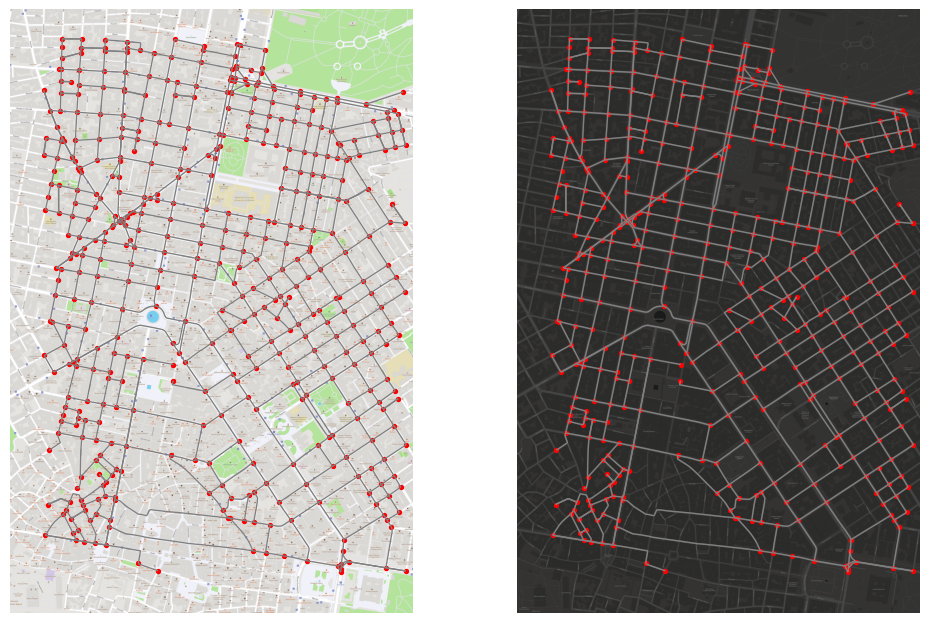

In [12]:
# Map visualization via tbd.plot_map
bounds = [23.723577, 37.975462, 23.738471, 37.993053]

fig = plt.figure(1, (12, 8), dpi=100)
ax = plt.subplot(121)
plt.sca(ax)
tbd.plot_map(plt, bounds, zoom=18, style=1) # the map
edges.plot(ax=ax, lw=1, color='grey') # edges
nodes.plot(ax=ax, markersize = 8, color='red') # nodes
plt.axis('off');

ax = plt.subplot(122)
plt.sca(ax)
tbd.plot_map(plt, bounds, zoom=18, style=5) # the map
edges.plot(ax=ax, lw=1, color='grey') # edges
nodes.plot(ax=ax, markersize = 8, color='red') # nodes
plt.axis('off');

## Data Cleaning

### Data Sparisify

The sampling interval in this dataset is $0.04$ second, which is amazing.  
However, some marcoscopic studies do not need such a high-frequency for better processing efficiency. In this case, the data can be sparsified using tbd.XXX.

In [12]:
# the origin data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581244 entries, 0 to 581243
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   track_id  581244 non-null  int64         
 1   lon       581244 non-null  float64       
 2   lat       581244 non-null  float64       
 3   speed     581244 non-null  float64       
 4   time      581244 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 22.2 MB


In [14]:
data_sparsify = tbd.traj_sparsify(data, col=['track_id', 'time', 'lon', 'lat'], 
                                  timegap=0.4, 
                                  method='subsample') # do not using interpolate method
data_sparsify.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23293 entries, 0 to 581229
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  23293 non-null  int64         
 1   lon       23293 non-null  float64       
 2   lat       23293 non-null  float64       
 3   speed     23293 non-null  float64       
 4   time      23293 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.1 MB


### Data compress

Remove the stopped points except for the first and the last point for each vehicle.

In [16]:
# tbd清理中间不动的数据点
data_sparsify_clean = tbd.clean_same(data_sparsify, col=['track_id', 'time', 'lon', 'lat'])
data_sparsify_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10674 entries, 0 to 581229
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  10674 non-null  int64         
 1   lon       10674 non-null  float64       
 2   lat       10674 non-null  float64       
 3   speed     10674 non-null  float64       
 4   time      10674 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 500.3 KB


In [18]:
data_sparsify_clean.head()

,track_id,lon,lat,speed,time
0,128,23.730362,37.990046,12.5845,1970-01-01 00:00:00
25,128,23.730399,37.990040,10.6835,1970-01-01 00:00:01
50,128,23.730429,37.990036,7.8580,1970-01-01 00:00:02
75,128,23.730443,37.990033,1.2661,1970-01-01 00:00:03
1775,128,23.730443,37.990033,0.0027,1970-01-01 00:01:11


## Data Visualization

In [19]:
gdf_data = gpd.GeoDataFrame(data_sparsify_clean, 
                            geometry=gpd.points_from_xy(data_sparsify_clean['lon'], 
                                                        data_sparsify_clean['lat']), 
                            crs=4326)
gdf_data.head()

,track_id,lon,lat,speed,time,geometry
0,128,23.730362,37.990046,12.5845,1970-01-01 00:00:00,POINT (23.73036 37.99005)
25,128,23.730399,37.990040,10.6835,1970-01-01 00:00:01,POINT (23.73040 37.99004)
50,128,23.730429,37.990036,7.8580,1970-01-01 00:00:02,POINT (23.73043 37.99004)
75,128,23.730443,37.990033,1.2661,1970-01-01 00:00:03,POINT (23.73044 37.99003)
1775,128,23.730443,37.990033,0.0027,1970-01-01 00:01:11,POINT (23.73044 37.99003)


In [43]:
# get the vehicle list of top-ranked number of points
gdf_count = gdf_data.groupby('track_id')['lon'].count().rename('count').sort_values(ascending=False).reset_index()
print(list(gdf_count.iloc[:20]['track_id']))

[2138, 3290, 1442, 3197, 4408, 1767, 5002, 5022, 2140, 347, 2584, 4750, 4542, 2431, 4905, 4997, 1329, 4263, 1215, 3400]


Visualization of all vehicles

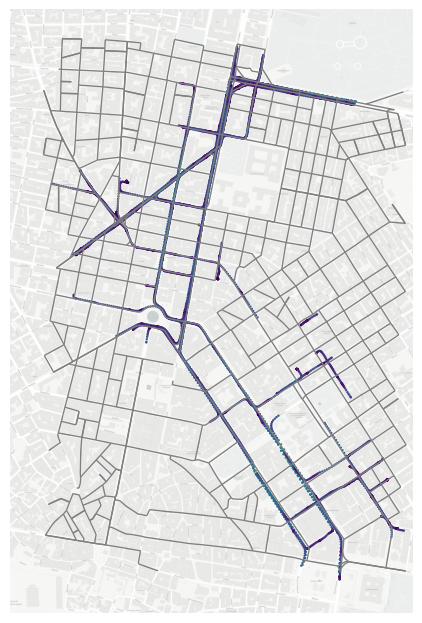

In [25]:
fig = plt.figure(1, (6, 8), dpi=100)

ax = plt.subplot(111)
plt.sca(ax)

# map
tbd.plot_map(plt, bounds, zoom=18, style=4) # the map
edges.plot(ax=ax, lw=1, color='grey') # edges
# nodes.plot(ax=ax, markersize = 6, color='red') # nodes

# trajectory
gdf_data.plot(column='speed', ax=ax, markersize=0.5)

plt.axis('off');

Visualization of a single vehicle, and show the shortes path

In [66]:
# select a vehicle
tmpgdf_data = gdf_data[gdf_data['track_id']==2138]

# the origin / destination location
# o_point = [tmpgdf_data.iloc[0]['lon'], tmpgdf_data.iloc[0]['lat']]
# d_point = [tmpgdf_data.iloc[-1]['lon'], tmpgdf_data.iloc[-1]['lat']]

# get the nearest node of each point on the map
tmpgdf_data = tbd.ckdnearest_point(tmpgdf_data, nodes)

# extract the o/d node
o_index, d_index = tmpgdf_data.iloc[0]['index'], tmpgdf_data.iloc[-1]['index']
o_node_id, d_node_id = list(nodes[nodes['index']==o_index].index)[0], \
                       list(nodes[nodes['index']==d_index].index)[0]
print(o_node_id, d_node_id)

tmpgdf_data.head()

250691723 358465943


/Applications/anaconda3/envs/data/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,track_id,lon,lat,speed,time,geometry_x,dist,index,y,x,street_count,highway,geometry_y
0,2138,23.735287,37.977435,42.1006,1970-01-01 00:01:35.560,POINT (23.73529 37.97743),0.000779,145,37.978086,23.734859,4,NaN,POINT (23.73486 37.97809)
1,2138,23.735254,37.977473,41.8663,1970-01-01 00:01:36.000,POINT (23.73525 37.97747),0.000729,145,37.978086,23.734859,4,NaN,POINT (23.73486 37.97809)
2,2138,23.735181,37.977558,39.9012,1970-01-01 00:01:37.000,POINT (23.73518 37.97756),0.000618,145,37.978086,23.734859,4,NaN,POINT (23.73486 37.97809)
3,2138,23.735111,37.977638,37.7748,1970-01-01 00:01:38.000,POINT (23.73511 37.97764),0.000514,145,37.978086,23.734859,4,NaN,POINT (23.73486 37.97809)
4,2138,23.735047,37.977712,33.8450,1970-01-01 00:01:39.000,POINT (23.73505 37.97771),0.000418,145,37.978086,23.734859,4,NaN,POINT (23.73486 37.97809)


250691723 358465943


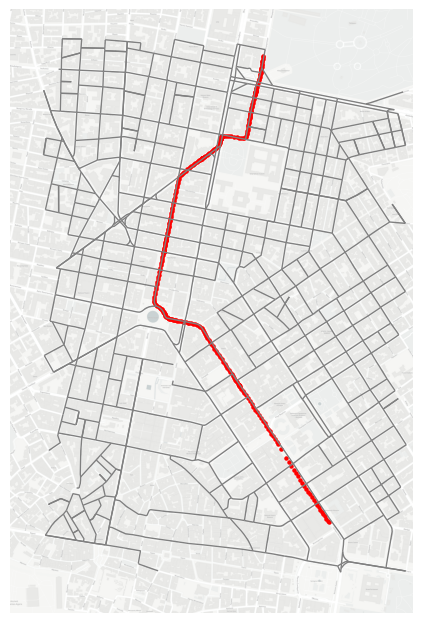

In [91]:
fig = plt.figure(1, (6, 8), dpi=100)

ax = plt.subplot(111)
plt.sca(ax)

# map
tbd.plot_map(plt, bounds, zoom=18, style=4) # the map
edges.plot(ax=ax, lw=1, color='grey') # edges
# nodes.plot(ax=ax, markersize = 6, color='red') # nodes

# trajectory
gdf_data[gdf_data['track_id']==2138].plot(ax=ax, markersize=5, color='red')


plt.axis('off');

Users can compared the path with the shortes path.

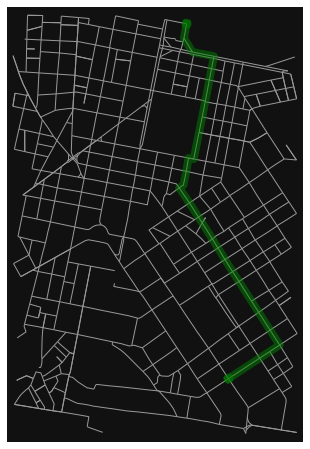

In [92]:
# the shortest path (optional)
# ax = plt.subplot(122)
# plt.sca(ax)
route = ox.shortest_path(G, o_node_id, d_node_id, weight="length")
plt, ax = ox.plot_graph_route(G, route, route_color="green", route_linewidth=8, node_size=0)